In [17]:
# Author: Ernesto Rodríguez
# github.com/ernestorodg

###############################################################################
## Analyse Bezerra's dataset for intrusion detection using Decision Trees
###############################################################################

In [18]:
import pandas as pd
import numpy as np
import sys

###############################################################################
## Define constants 
###############################################################################


# Random state for reproducibility
STATE = 0
np.random.seed(10)
# List of available attacks on the dataset


# Especific to the repository 
DATASET_DIRECTORY = r'../datasets/Dataset-bezerra-IoT-20200528T203526Z-001/Dataset-IoT/'
NETFLOW_DIRECTORY = r'NetFlow/'


# There are different csv files on the Dataset, with different types of data:

# Some meanings:
# MC: Media Center
# I: One hour of legitimate and malicious NetFlow data from profile.
# L: One hour of legitimate NetFlow data from profile.

MC = r'MC/'
ST = r'ST/'
SC = r'SC/'


# MC_I_FIRST: Has infected data by Hajime, Aidra and BashLite botnets 
MC_I_FIRST = r'MC_I1.csv'

# MC_I_SECOND: Has infected data from Mirai botnets
MC_I_SECOND = r'MC_I2.csv'

# MC_I_THIR: Has infected data from Mirai, Doflo, Tsunami and Wroba botnets
MC_I_THIRD = r'MC_I3.csv'

# MC_L: Has legitimate data, no infection
MC_L = r'MC_L.csv'


# Constants for ST
ST_I_FIRST = r'ST_I1.csv'
ST_I_SECOND = r'ST_I2.csv'
ST_I_THIRD = r'ST_I3.csv'
ST_L = r'ST_L.csv'

# Constants for SC
SC_I_FIRST = r'SC_I1.csv'
SC_I_SECOND = r'SC_I2.csv'
SC_I_THIRD = r'SC_I3.csv'
SC_L = r'SC_L.csv'


In [19]:
###############################################################################
## Load dataset
###############################################################################

# For MC data:
df_mc_I_first = pd.read_csv (DATASET_DIRECTORY + MC + NETFLOW_DIRECTORY + MC_I_FIRST)
df_mc_I_second = pd.read_csv (DATASET_DIRECTORY + MC + NETFLOW_DIRECTORY + MC_I_SECOND)
df_mc_I_third = pd.read_csv (DATASET_DIRECTORY + MC + NETFLOW_DIRECTORY + MC_I_THIRD)

# Add legitimate rows from MC_L
legitimate_frame_mc = pd.read_csv (DATASET_DIRECTORY + MC + NETFLOW_DIRECTORY + MC_L)

###################

# For ST data:
df_st_I_first = pd.read_csv (DATASET_DIRECTORY + ST + NETFLOW_DIRECTORY + ST_I_FIRST)
df_st_I_second = pd.read_csv (DATASET_DIRECTORY + ST + NETFLOW_DIRECTORY + ST_I_SECOND)
df_st_I_third = pd.read_csv (DATASET_DIRECTORY + ST + NETFLOW_DIRECTORY + ST_I_THIRD)

# Add legitimate rows from SC_L
legitimate_frame_st = pd.read_csv (DATASET_DIRECTORY + ST + NETFLOW_DIRECTORY + ST_L)


###################

# For SC data:
df_sc_I_first = pd.read_csv (DATASET_DIRECTORY + SC + NETFLOW_DIRECTORY + SC_I_FIRST)
df_sc_I_second = pd.read_csv (DATASET_DIRECTORY + SC + NETFLOW_DIRECTORY + SC_I_SECOND)
df_sc_I_third = pd.read_csv (DATASET_DIRECTORY + SC + NETFLOW_DIRECTORY + SC_I_THIRD)

# Add legitimate rows from MC_L
legitimate_frame_sc = pd.read_csv (DATASET_DIRECTORY + SC + NETFLOW_DIRECTORY + SC_L)

dataframes_list = [df_mc_I_first,
                df_mc_I_second,
                df_mc_I_third,
                legitimate_frame_mc,
                df_st_I_first,
                df_st_I_second,
                df_st_I_third,
                legitimate_frame_st,
                df_sc_I_first,
                df_sc_I_second,
                df_sc_I_third,
                legitimate_frame_sc]

# Joining the differents DataFrames
prev_df = pd.concat(dataframes_list)



In [20]:
###############################################################################
## Modify the DataFrame
###############################################################################


# Sample the dataset if necessary
df = prev_df.sample (frac = 1, replace = True, random_state = 0)

# We can see that this dataset has a temporal description.
# So it is not a good idea to randomly remove rows

# In this case we drop the index column, since pandas library creates an index
# automatically. 
df = df.drop(df.columns[0], axis=1)

# Also drop columns that has no significant data
df = df.drop(df.columns[14:], axis=1)

# Initial and end time is not a good feature for svm model
df = df.drop(['ts', 'te'], axis=1)

# Trying another drops to see relation between features and results
df = df.drop(['fwd', 'stos'], axis=1)
# 'sp', 'dp', 'sa',  'da',  

# Counting number of null data
nanColumns = [i for i in df.columns if df [i].isnull ().any ()]

# Remove NaN and inf values
df.replace ('Infinity', np.nan, inplace = True) ## Or other text values
df.replace (np.inf, np.nan, inplace = True) ## Remove infinity
df.replace (np.nan, 0, inplace = True)


# if (df.Label.value_counts()[1] < df.Label.value_counts()[0]):
#     remove_n =  df.Label.value_counts()[0] - df.Label.value_counts()[1]  # Number of rows to be removed   
#     print(remove_n)
#     df_to_be_dropped = df[df.Label == 0]
#     drop_indices = np.random.choice(df_to_be_dropped.index, remove_n, replace=False)
#     df = df.drop(drop_indices)
# else: 
#     remove_n =  df.Label.value_counts()[1] - df.Label.value_counts()[0]  # Number of rows to be removed   
#     print(remove_n)
#     df_to_be_dropped = df[df.Label == 1]
#     drop_indices = np.random.choice(df_to_be_dropped.index, remove_n, replace=False)
#     df = df.drop(drop_indices)


In [21]:
###############################################################################
## Slice the dataframe (usually the last column is the target)
###############################################################################

X = pd.DataFrame(df.iloc [:, 1:])

# Selecting other columns
# X = pd.concat([X, df.iloc[:, 2]], axis=1)

y = df.iloc [:, 0]
print('Number of non-attacks: ', y.value_counts()[0])
print('Number of attacks: ', y.value_counts()[1])

# See Output, only available on jupyter-notebooks
# X

Number of non-attacks:  7998
Number of attacks:  1716408


In [22]:
###############################################################################
## Create artificial non-attacks samples using Random Oversampling
###############################################################################

from imblearn.over_sampling import RandomOverSampler # doctest: +NORMALIZE_WHITESPACE

ros = RandomOverSampler(random_state=42)

X, y = ros.fit_resample(X, y)

print('Number of non-attacks: ', y.value_counts()[0])
print('Number of attacks: ', y.value_counts()[1])

Number of non-attacks:  1716408
Number of attacks:  1716408


In [23]:
###############################################################################
## Split dataset into train and test sets if not using cross validation
###############################################################################
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split (X, y, test_size = 1/5,
                                                     random_state = STATE)

X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

X_train.shape

(2746252, 9)

In [24]:
X_test.shape

(686564, 9)

In [25]:
####################################################################
# Treat categorical data on train set
####################################################################
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder


cat_cols = X_train.columns[X_train.dtypes == 'O'] # Returns array with the columns that has Object types elements

categories = [
    X_train[column].unique() for column in X_train[cat_cols]]

for cat in categories:
    cat[cat == None] = 'missing'  # noqa

# Replacing missing values
categorical_imputer = SimpleImputer(missing_values=None, 
                                    strategy='constant', 
                                    fill_value='missing')

X_train[cat_cols] = categorical_imputer.fit_transform(X_train[cat_cols])

# Encoding the categorical data
categorical_encoder = OrdinalEncoder(categories = categories)
categorical_encoder.fit(X_train[cat_cols])
X_train[cat_cols] = categorical_encoder.transform(X_train[cat_cols])


In [26]:
####################################################################
# Treat categorical data on test set
####################################################################
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder


cat_cols = X_test.columns[X_test.dtypes == 'O'] # Returns array with the columns that has Object types elements

categories = [
    X_test[column].unique() for column in X_test[cat_cols]]

for cat in categories:
    cat[cat == None] = 'missing'  # noqa

# Replacing missing values
categorical_imputer = SimpleImputer(missing_values=None, 
                                    strategy='constant', 
                                    fill_value='missing')

X_test[cat_cols] = categorical_imputer.fit_transform(X_test[cat_cols])

# Encoding the categorical data
categorical_encoder = OrdinalEncoder(categories = categories)
categorical_encoder.fit(X_test[cat_cols])
X_test[cat_cols] = categorical_encoder.transform(X_test[cat_cols])


In [27]:
X_test

,td,sa,da,sp,dp,pr,flg,ipkt,ibyt
104004,0.0,0.0,0.0,40758,23.0,0.0,0.0,1.0,40.0
2694353,0.0,1.0,1.0,64205,10505.0,1.0,1.0,1.0,125.0
3001901,122821.0,2.0,2.0,443,54416.0,0.0,2.0,10976.0,16429973.0
720671,0.0,0.0,3.0,46412,81.0,0.0,0.0,1.0,40.0
206690,0.0,0.0,4.0,45130,23.0,0.0,0.0,1.0,40.0
...,...,...,...,...,...,...,...,...,...
597178,0.0,0.0,276171.0,10688,23.0,0.0,0.0,1.0,40.0
3304576,71.0,0.0,7.0,53705,53.0,1.0,1.0,1.0,59.0
722033,0.0,0.0,276172.0,51491,23.0,0.0,0.0,1.0,40.0
1280184,0.0,0.0,276173.0,39907,23.0,0.0,0.0,1.0,40.0


In [13]:
# ####################################################################
# # Treat categorical data on train set
# ####################################################################

# cat_cols = X_train.columns[X_train.dtypes == 'O'] # Returns array with the columns that has Object types elements


# categories = [
#     X_train[column].unique() for column in X_train[cat_cols]]

# for cat in categories:
#     cat[cat == None] = 'missing'  # noqa

# # Replacing missing values
# categorical_imputer = SimpleImputer(missing_values=None, 
#                                     strategy='constant', 
#                                     fill_value='missing')

# X_train[cat_cols] = categorical_imputer.fit_transform(X_train[cat_cols])

# # Encoding the categorical data
# categorical_encoder = OrdinalEncoder(categories = categories)

# X_train[cat_cols] = categorical_encoder.fit_transform(X_train[cat_cols])

# # Scaling new numerical values

# numerical_imputer = SimpleImputer(strategy = "mean")
# X_train[cat_cols] = numerical_imputer.fit_transform(X_train[cat_cols])

# numerical_scaler = StandardScaler()
# X_train[cat_cols] = numerical_scaler.fit_transform(X_train[cat_cols])



In [14]:
####################################################################
# Treat numerical data 
####################################################################
from sklearn.preprocessing import StandardScaler


num_cols = X_train.columns[(X_train.dtypes == 'float64') | (X_train.dtypes == 'int64')] # Returns array with the columns that has float types elements

# Scaling numerical values

numerical_scaler = StandardScaler()
numerical_scaler.fit(X_train)
X_train = numerical_scaler.transform(X_train)

numerical_scaler.fit(X_train)
X_test = numerical_scaler.transform(X_test)

# X_train

In [28]:
X_test

,td,sa,da,sp,dp,pr,flg,ipkt,ibyt
104004,0.0,0.0,0.0,40758,23.0,0.0,0.0,1.0,40.0
2694353,0.0,1.0,1.0,64205,10505.0,1.0,1.0,1.0,125.0
3001901,122821.0,2.0,2.0,443,54416.0,0.0,2.0,10976.0,16429973.0
720671,0.0,0.0,3.0,46412,81.0,0.0,0.0,1.0,40.0
206690,0.0,0.0,4.0,45130,23.0,0.0,0.0,1.0,40.0
...,...,...,...,...,...,...,...,...,...
597178,0.0,0.0,276171.0,10688,23.0,0.0,0.0,1.0,40.0
3304576,71.0,0.0,7.0,53705,53.0,1.0,1.0,1.0,59.0
722033,0.0,0.0,276172.0,51491,23.0,0.0,0.0,1.0,40.0
1280184,0.0,0.0,276173.0,39907,23.0,0.0,0.0,1.0,40.0


In [29]:
# ###############################################################################
# ## Apply normalization
# ###############################################################################

# print ('Applying normalization (standard)')
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler ()
# scaler.fit (X_train)

# #print ('Mean before scalling:', scaler.mean_)
# X_train = scaler.transform (X_train)
# scaler.fit (X_train)
# #print ('Mean after scalling:', scaler.mean_)

# scaler.fit (X_test)
# X_test = scaler.transform (X_test)
X_train.shape

(2746252, 9)

In [30]:
###############################################################################
## Training the model without cross-validation (simpler than the training above)
###############################################################################

# scikit-learn uses an optimised version of the CART algorithm;
# however, scikit-learn implementation does not support categorical variables for now


from sklearn import tree
import time

# Assign the model to be used
clf = tree.DecisionTreeClassifier()

In [31]:
X_test.shape

(686564, 9)

In [32]:
# ###############################################################################
# ## Making a Grid Search, with validation
# ###############################################################################

# from sklearn.model_selection import GridSearchCV


# criterion = {'criterion' : ['gini', 'entropy']}
# splitter = {'splitter' : ['best', 'random']}
# max_depth = {'max_depth' : [1, 10, 100, 1000, 10000, 100000, 1000000, None]}
# min_samples_split = {'min_samples_split' : [2, 3, 4]}

# grid_tree = GridSearchCV(clf, param_grid = [criterion, splitter, max_depth, min_samples_split] ,scoring = 'f1')
# grid_tree.fit(X_train, y_train)


# #Predict values based on new parameters
# y_pred = grid_tree.predict(X_test)



In [33]:
# ###############################################################################
# ## Obtain metrics from the model above
# ###############################################################################

# from sklearn.metrics import precision_score
# from sklearn.metrics import recall_score
# from sklearn.metrics import accuracy_score
# from sklearn.metrics import multilabel_confusion_matrix
# from sklearn.metrics import f1_score
# from sklearn.metrics import confusion_matrix

# # New Model Evaluation metrics 
# print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred)))
# print('Precision Score : ' + str(precision_score(y_test,y_pred)))
# print('Recall Score : ' + str(recall_score(y_test,y_pred)))
# print('F1 Score : ' + str(f1_score(y_test,y_pred)))

# #Logistic Regression (Grid Search) Confusion matrix
# confusion_matrix(y_test,y_pred)

In [34]:
X_test


,td,sa,da,sp,dp,pr,flg,ipkt,ibyt
104004,0.0,0.0,0.0,40758,23.0,0.0,0.0,1.0,40.0
2694353,0.0,1.0,1.0,64205,10505.0,1.0,1.0,1.0,125.0
3001901,122821.0,2.0,2.0,443,54416.0,0.0,2.0,10976.0,16429973.0
720671,0.0,0.0,3.0,46412,81.0,0.0,0.0,1.0,40.0
206690,0.0,0.0,4.0,45130,23.0,0.0,0.0,1.0,40.0
...,...,...,...,...,...,...,...,...,...
597178,0.0,0.0,276171.0,10688,23.0,0.0,0.0,1.0,40.0
3304576,71.0,0.0,7.0,53705,53.0,1.0,1.0,1.0,59.0
722033,0.0,0.0,276172.0,51491,23.0,0.0,0.0,1.0,40.0
1280184,0.0,0.0,276173.0,39907,23.0,0.0,0.0,1.0,40.0


In [35]:
###############################################################################
## Train the model with adjusted parameters
###############################################################################

# Measure time of this training
start_time = time.time()

# Assign the model to be used with adjusted parameters
clf = tree.DecisionTreeClassifier(criterion='entropy')

# Training the model
model = clf.fit(X_train, y_train)
print("--- %s seconds ---" % (time.time() - start_time))

--- 13.200364589691162 seconds ---


In [36]:
###############################################################################
## Obtain metrics from the trained model without cross-validation
###############################################################################
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix


# Predicting from the test slice
y_pred = model.predict(X_test)

# Precision == TP / (TP + FP)
print('Precision Score: ', precision_score(y_test, y_pred))

# Recall == TP / (TP + FN)
print('Recall Score: ', recall_score(y_test, y_pred))

# Accuracy 
train_score = model.score(X_test, y_test)
print('Accuracy: ', train_score)

# f1 
f_one_score = f1_score(y_test, y_pred)
print('F1 Score: ', f_one_score)

# Multilabel Confusion Matrix: 
# [tn fp]
# [fn tp]
print(multilabel_confusion_matrix(y_test, y_pred, labels=[0, 1]))

Precision Score:  0.986085860910388
Recall Score:  0.9995480390727511
Accuracy:  0.9927290099684807
F1 Score:  0.9927713146302684
[[[342795    155]
  [  4837 338777]]

 [[338777   4837]
  [   155 342795]]]


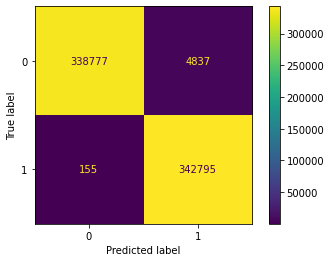

In [37]:
###############################################################################
## Plotting confusion matrix
###############################################################################
from sklearn.metrics import plot_confusion_matrix
from matplotlib import pyplot as plt

plot_confusion_matrix(model, X_test, y_test)  # doctest: +SKIP
plt.savefig("decision_tree_confusion_matrix.png", format="png")
plt.show()  # doctest: +SKIP
# td  sp  dp  pr  flg  ipkt ibyt